In [1]:
import torch
from functions import get_loader, plot_histories, plot_history
from ae_functions import train_autoencoder, validate_cae, visualize_latent_space, visualize_reconstruction, get_latent_dataset
from ae_models import DeepCAE, DeepBatchCAE, SimpleCAE, SimpleBatchCAE, SimpleCAE_Dropout, SimpleBatchDropoutCAE, DeepCAEWithPooling
import torch.nn as nn
from mlp_functions import train_mlp, validate_mlp, decision_level_fusion
from mlp_models import rawMLP, MLP, dropout_MLP, ImprovedMLP
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
##### CONFIG
NUM_EPOCHS = 20
LR_RATE = 1e-3
BATCH_SIZE = 8
WEIGHT_DECAY = 1e-5

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/fusion'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
OBJECTS = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

sensor_color = "color"
sensor_left = "icub_left"
sensor_right = "icub_right"
sensor_depth = "depthcolormap"

CUDA is available. Using GPU...


In [6]:
train_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, "training", batch_size=BATCH_SIZE)
val_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, "validation", batch_size=BATCH_SIZE)
test_loader = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, "testing", batch_size=BATCH_SIZE)

Epoch [1/20], AVG Loss: 0.4239, AVG PSNR: 20.6768, AVG SSIM: 0.6496


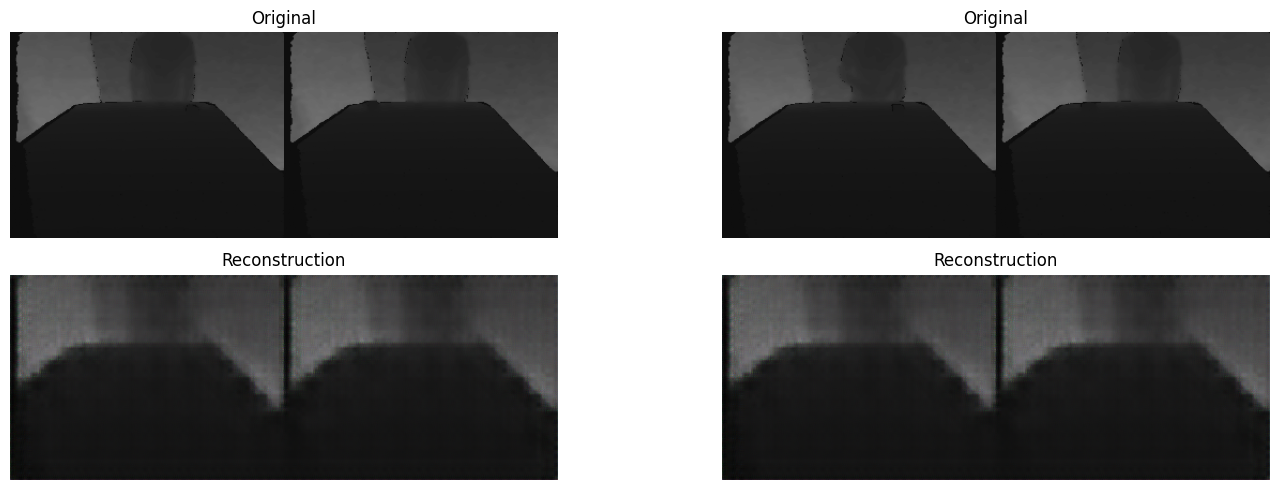

Epoch [2/20], AVG Loss: 0.4041, AVG PSNR: 27.6680, AVG SSIM: 0.8155


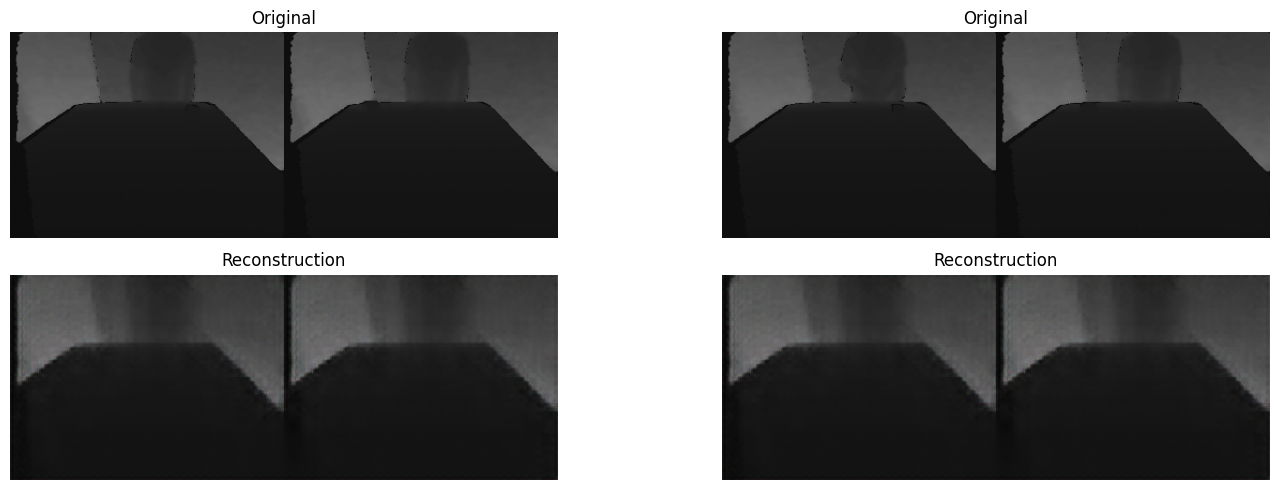

Epoch [3/20], AVG Loss: 0.4037, AVG PSNR: 28.8966, AVG SSIM: 0.8444


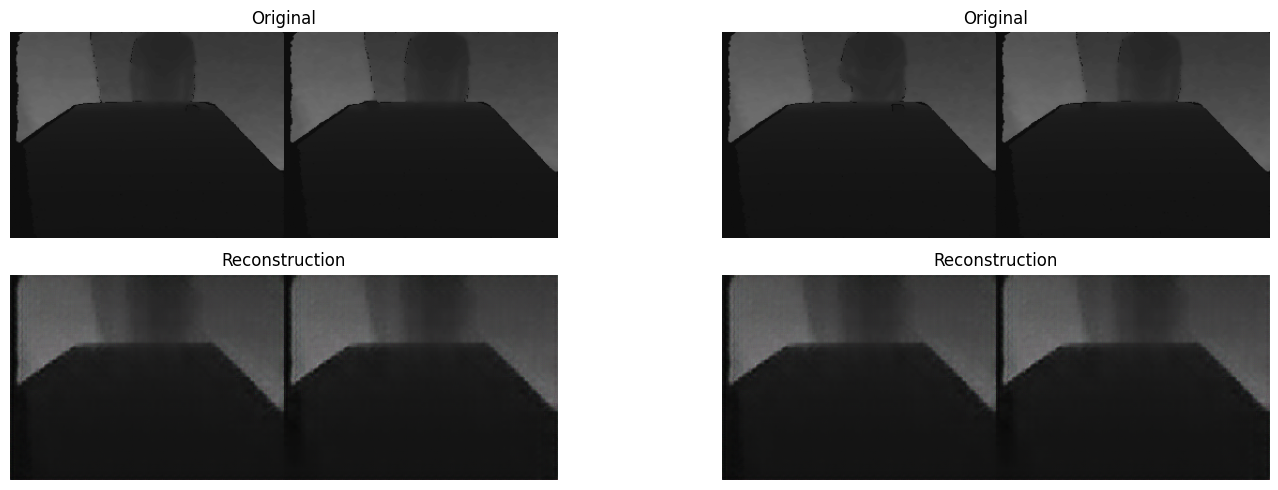

Epoch [4/20], AVG Loss: 0.4036, AVG PSNR: 29.3294, AVG SSIM: 0.8572


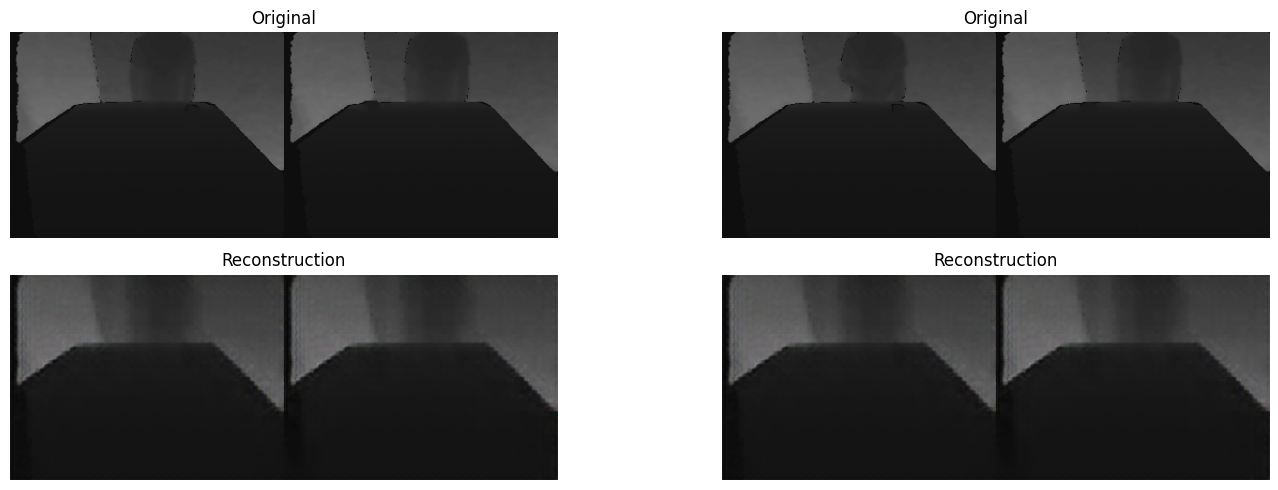

Epoch [5/20], AVG Loss: 0.4035, AVG PSNR: 29.6183, AVG SSIM: 0.8650


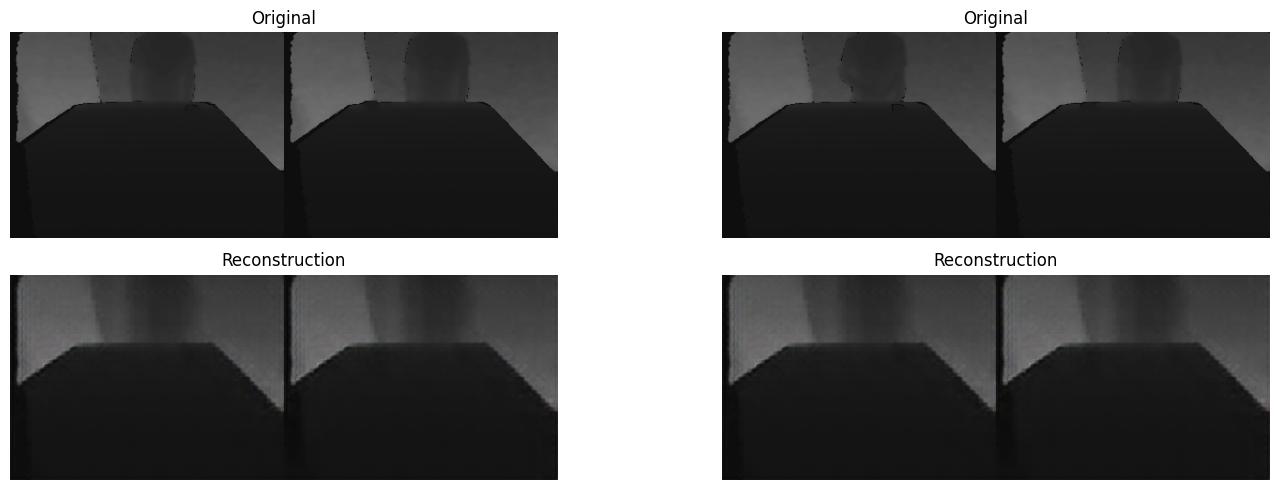

Epoch [6/20], AVG Loss: 0.4035, AVG PSNR: 29.8240, AVG SSIM: 0.8701


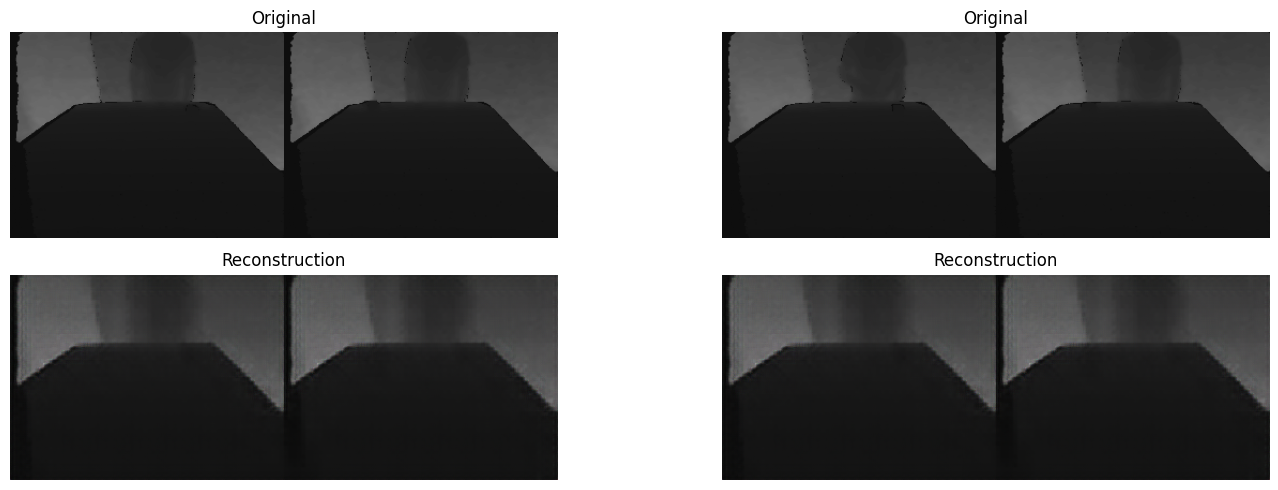

Epoch [7/20], AVG Loss: 0.4034, AVG PSNR: 30.0054, AVG SSIM: 0.8739


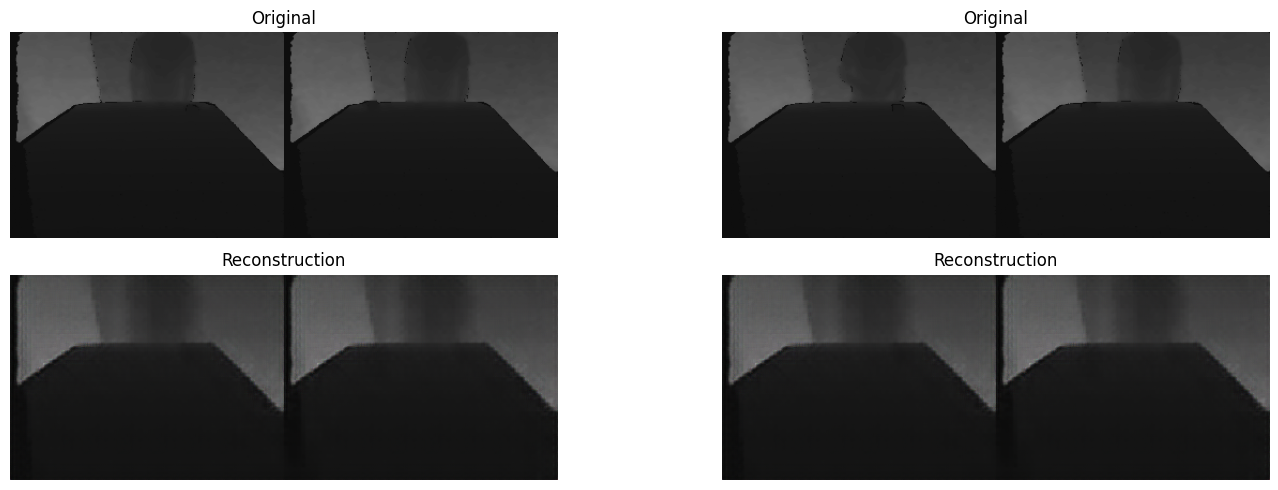

Epoch [8/20], AVG Loss: 0.4034, AVG PSNR: 30.1889, AVG SSIM: 0.8770


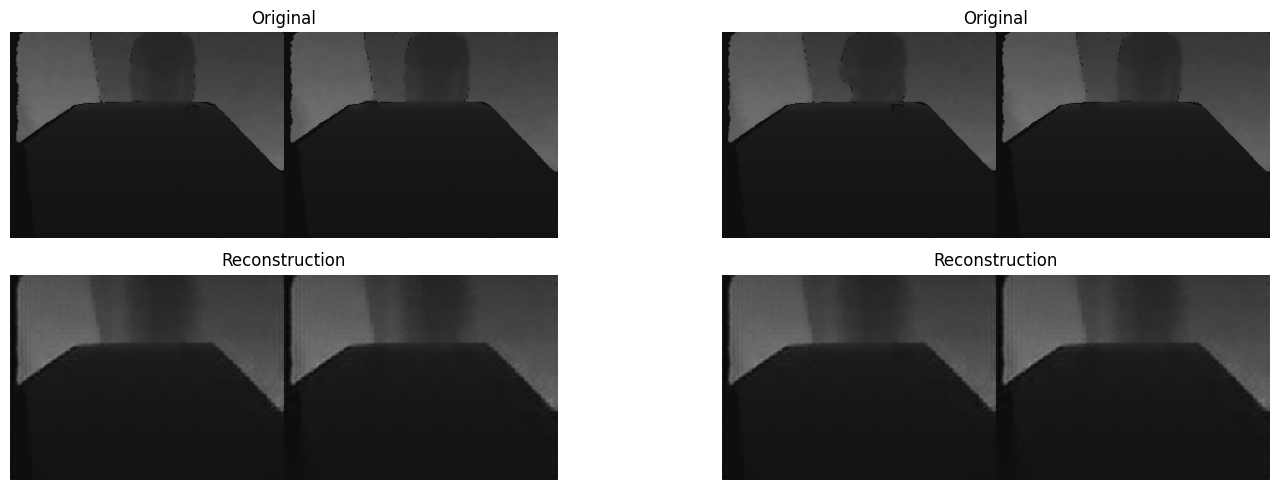

Epoch [9/20], AVG Loss: 0.4034, AVG PSNR: 30.3455, AVG SSIM: 0.8796


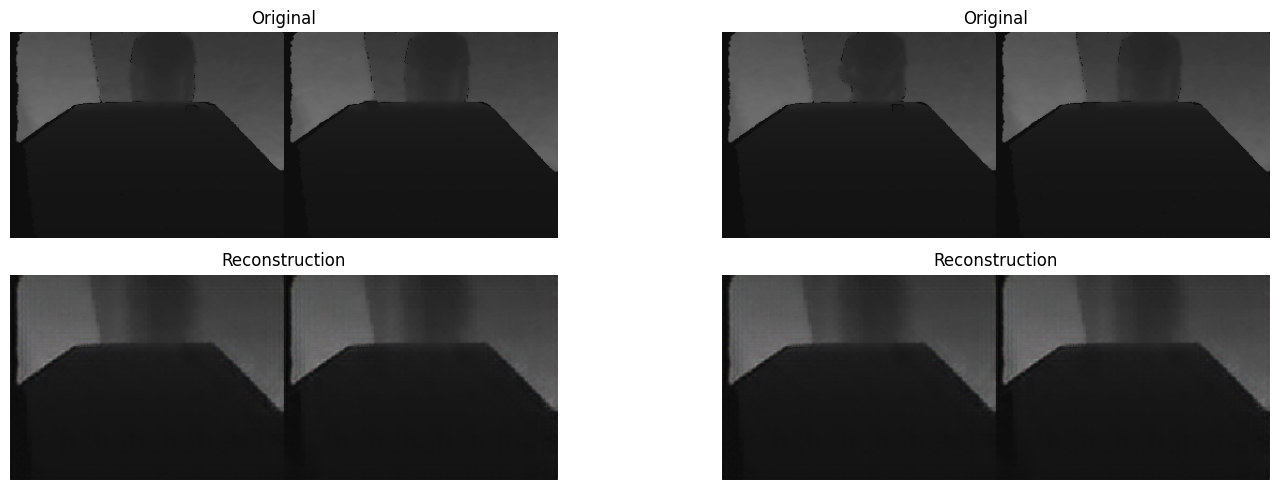

Epoch [10/20], AVG Loss: 0.4033, AVG PSNR: 30.5152, AVG SSIM: 0.8818


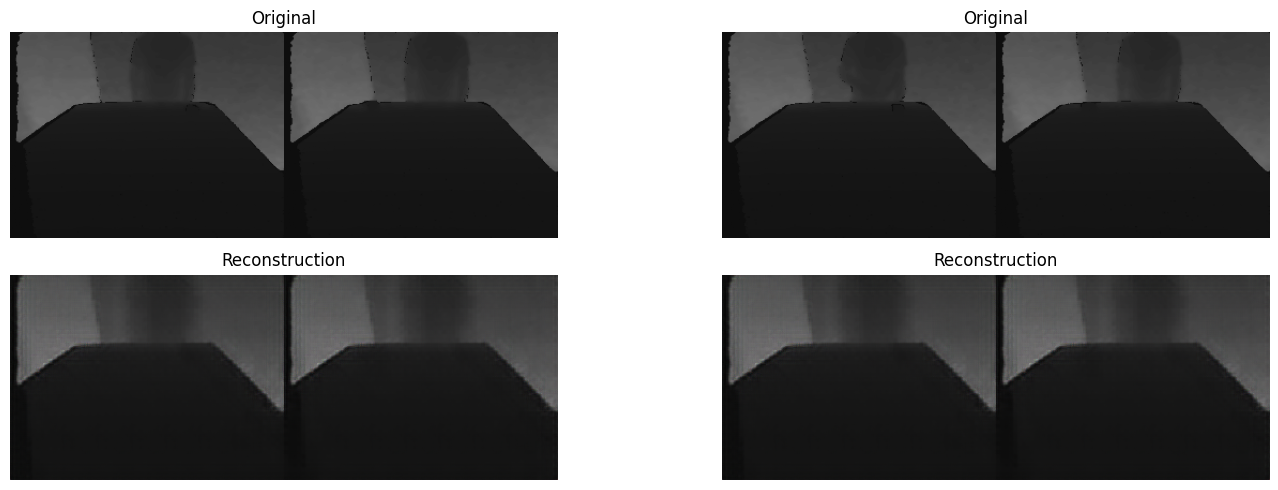

Epoch [11/20], AVG Loss: 0.4033, AVG PSNR: 30.6036, AVG SSIM: 0.8838


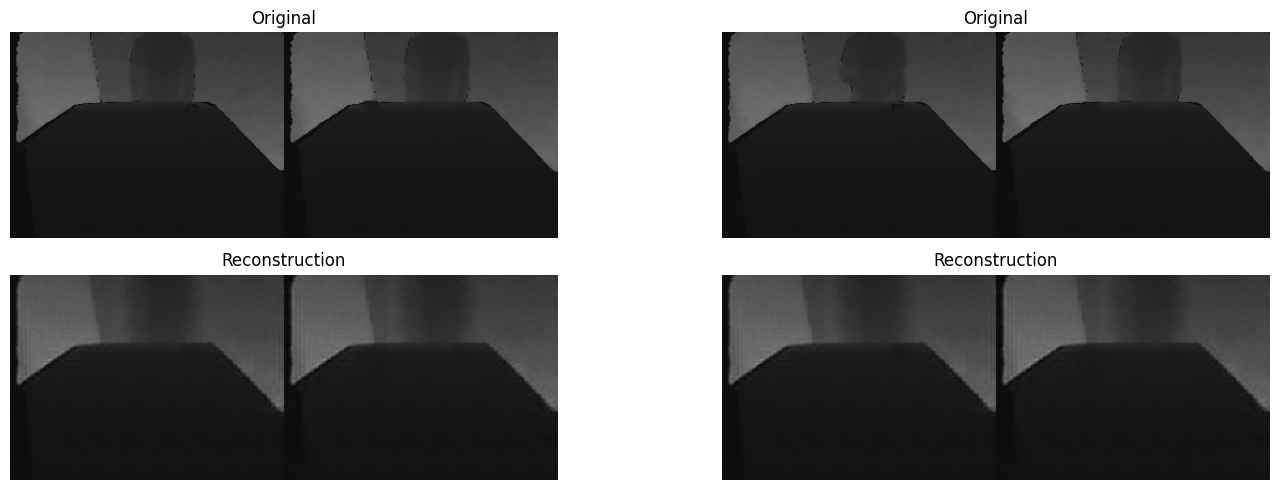

Epoch [12/20], AVG Loss: 0.4033, AVG PSNR: 30.8072, AVG SSIM: 0.8861


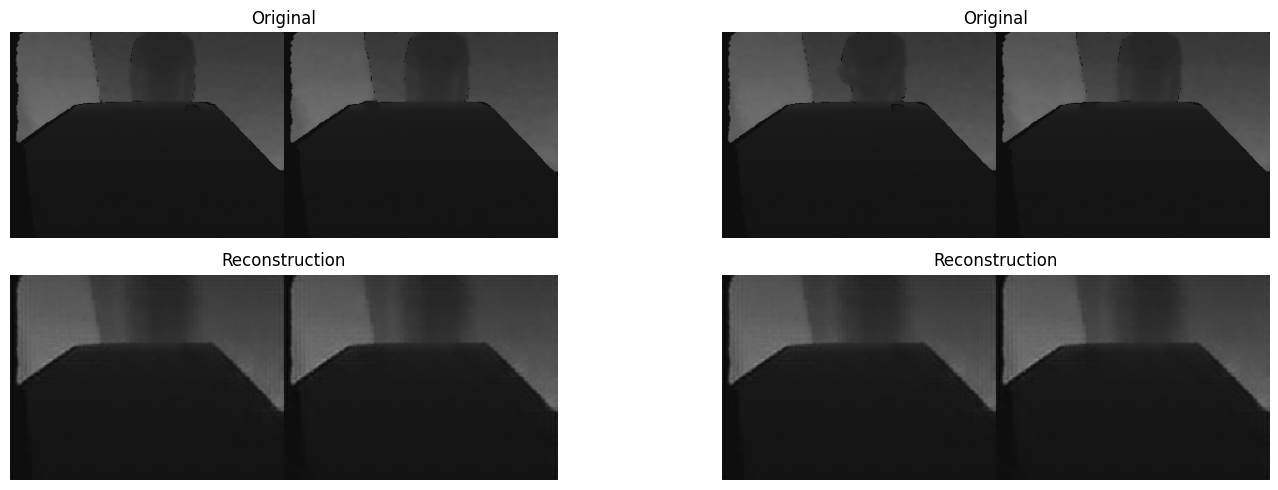

Epoch [13/20], AVG Loss: 0.4032, AVG PSNR: 30.8987, AVG SSIM: 0.8883


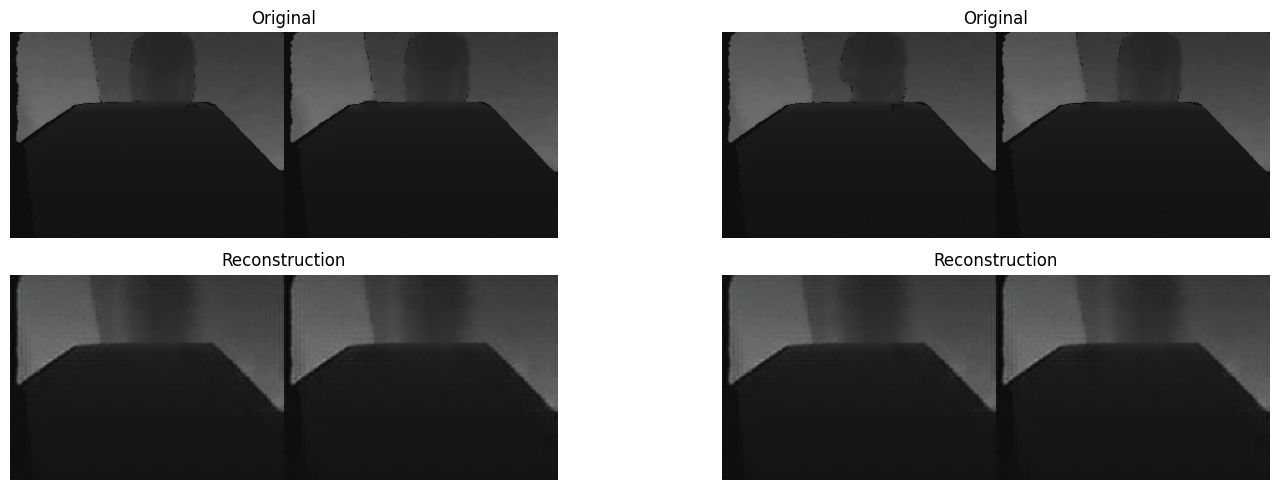

Epoch [14/20], AVG Loss: 0.4032, AVG PSNR: 30.9825, AVG SSIM: 0.8902


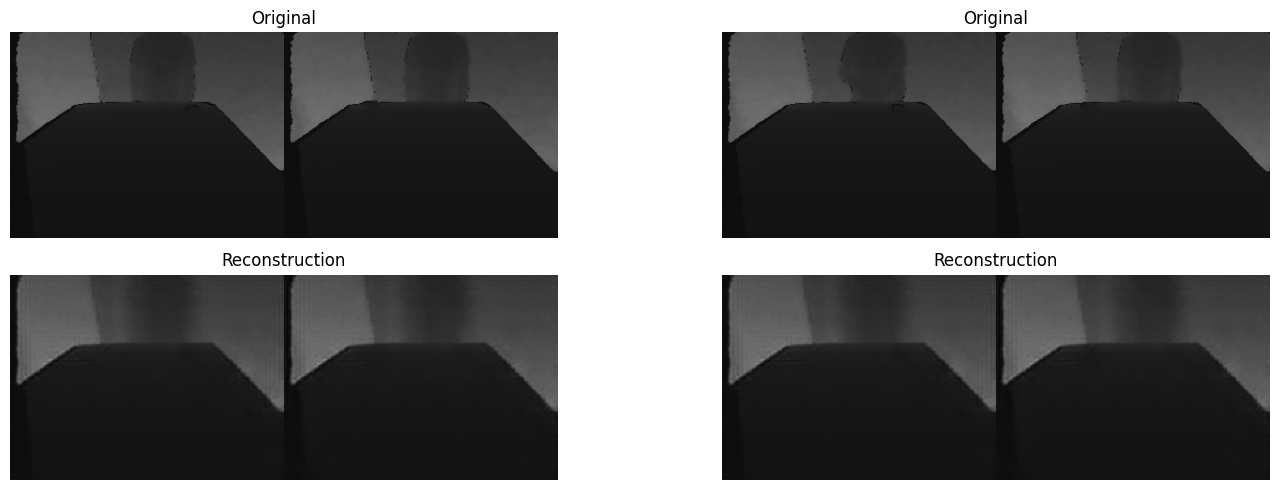

Epoch [15/20], AVG Loss: 0.4032, AVG PSNR: 31.1182, AVG SSIM: 0.8920


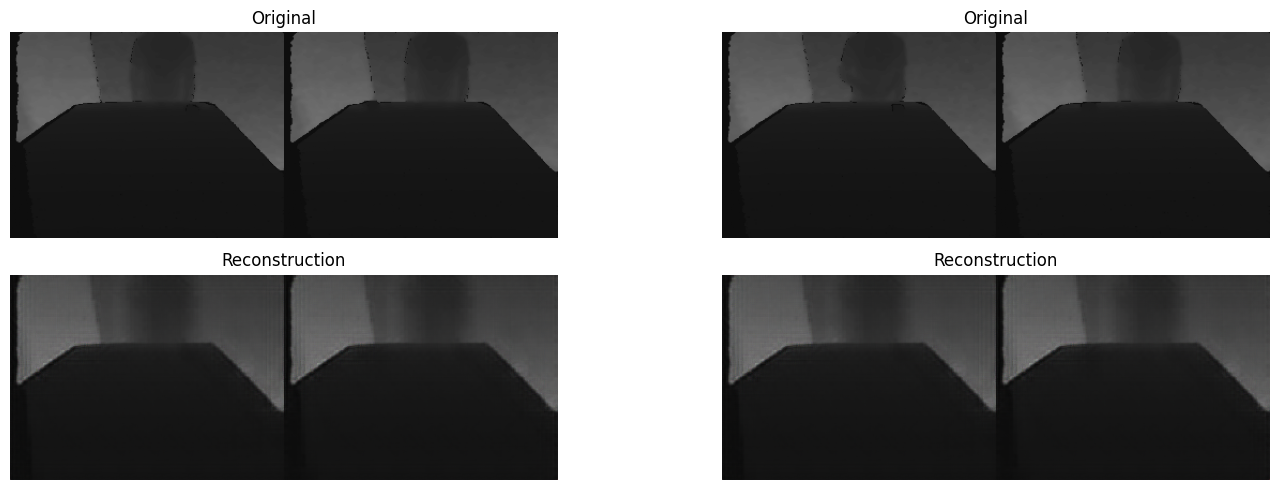

Epoch [16/20], AVG Loss: 0.4032, AVG PSNR: 31.1732, AVG SSIM: 0.8936


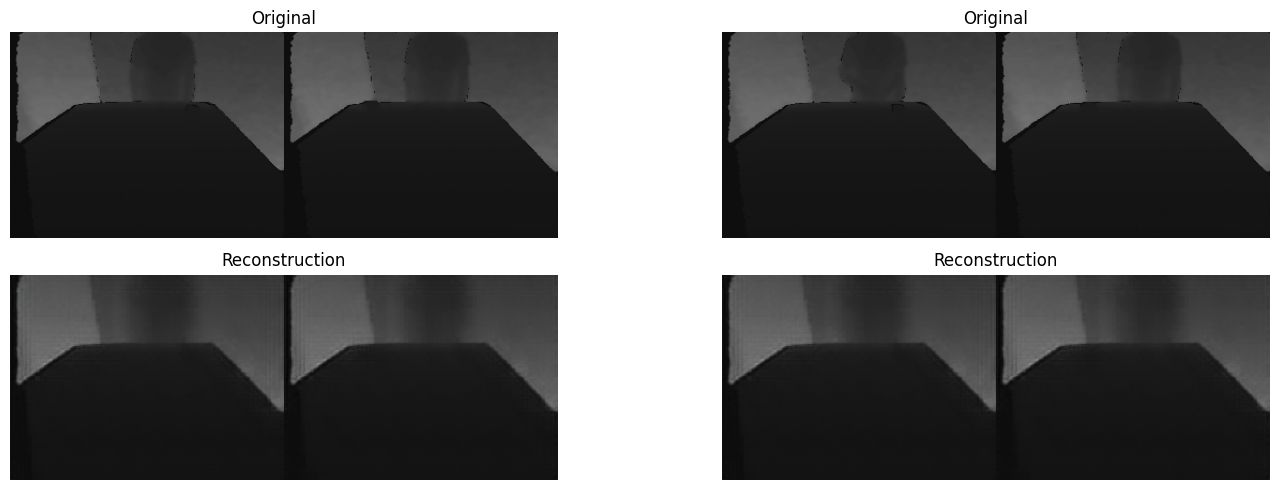

Epoch [17/20], AVG Loss: 0.4032, AVG PSNR: 31.3517, AVG SSIM: 0.8952


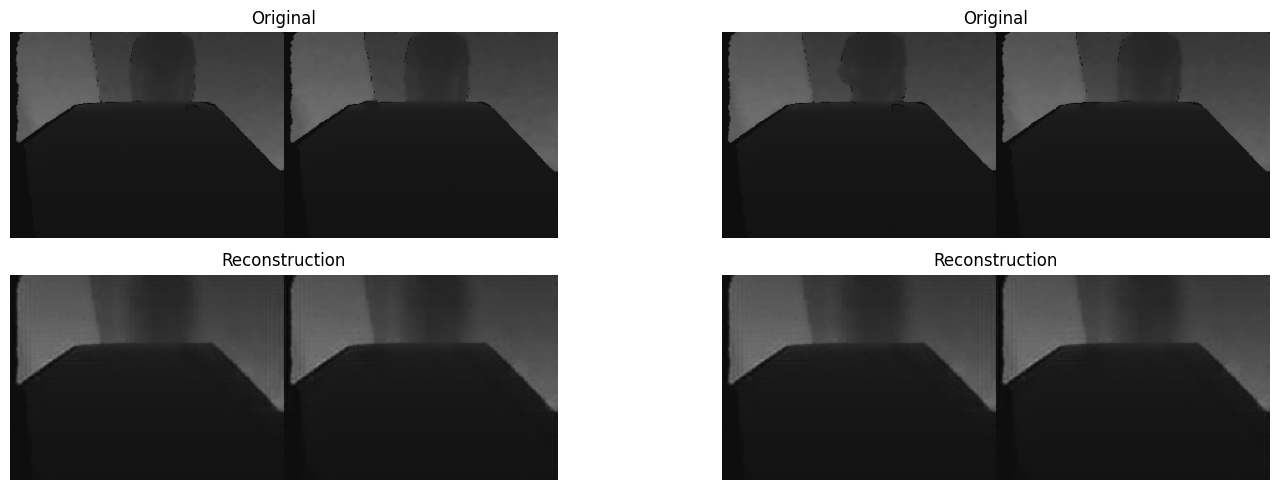

Epoch [18/20], AVG Loss: 0.4032, AVG PSNR: 31.3420, AVG SSIM: 0.8963


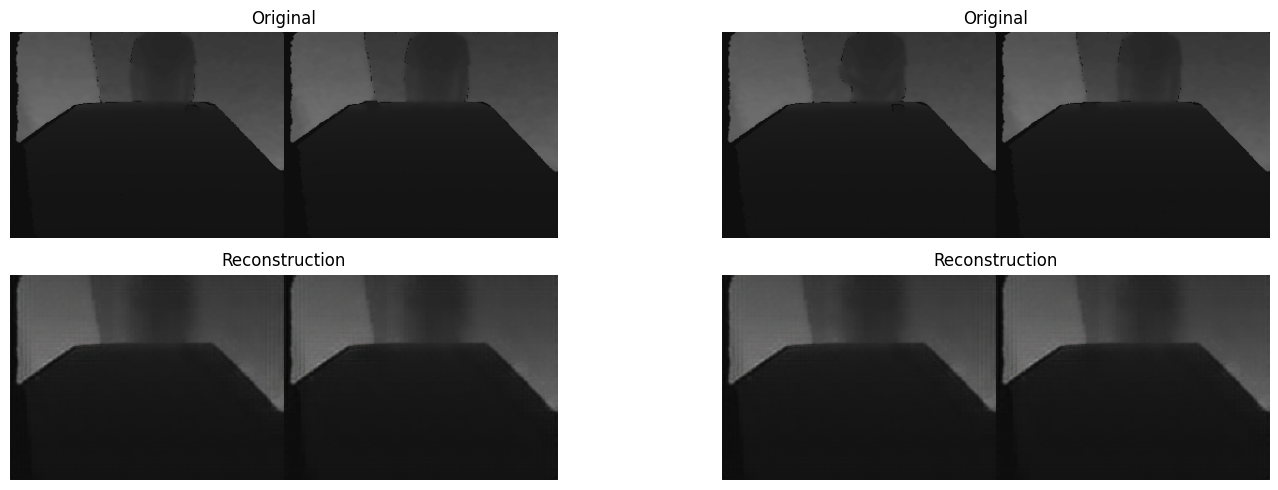

Epoch [19/20], AVG Loss: 0.4031, AVG PSNR: 31.5081, AVG SSIM: 0.8976


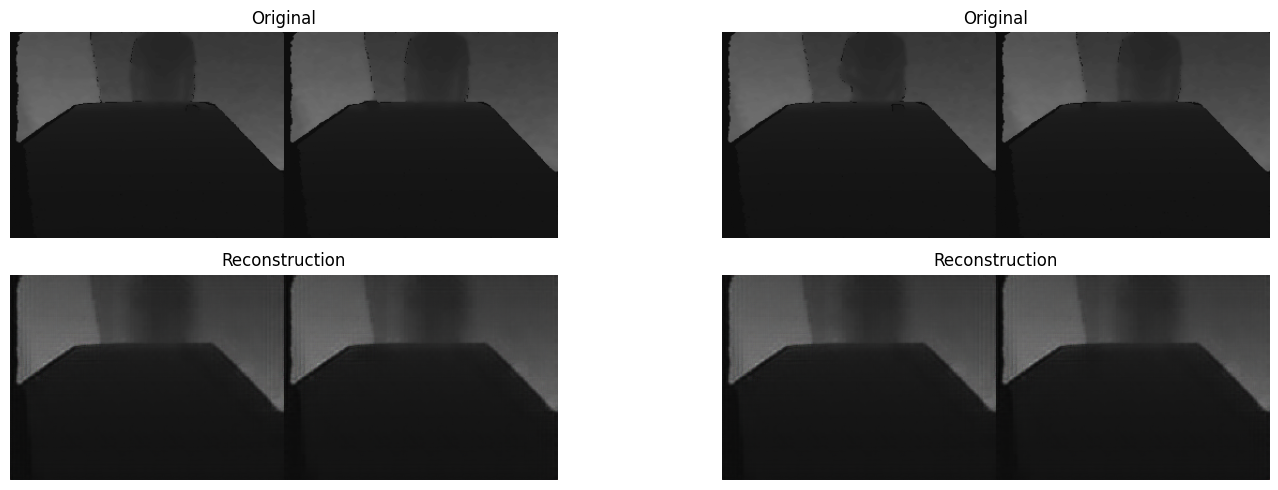

Epoch [20/20], AVG Loss: 0.4031, AVG PSNR: 31.5170, AVG SSIM: 0.8984


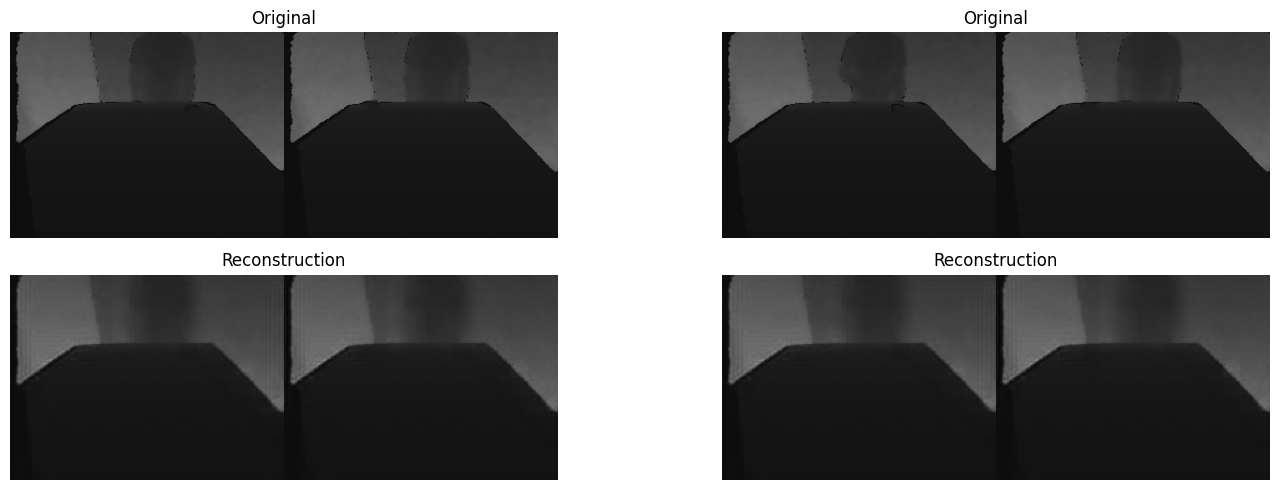

Average Validation Loss: 0.40321590937674046
Average PSNR: 30.811863374578223
Average SSIM: 0.8967062573177282


In [4]:
# cae_lossfunction = nn.MSELoss()
cae_lossfunction = nn.BCELoss()

#cae = SimpleCAE(input_channels=3).to(DEVICE)
#cae = SimpleBatchCAE(input_channels=3).to(DEVICE)
#cae = SimpleCAE_Dropout(input_channels=3).to(DEVICE)
#cae = SimpleBatchDropoutCAE(input_channels=3, dropout_rate=0.25).to(DEVICE)
#cae = DeepCAE(input_channels=3).to(DEVICE)
#cae = DeepBatchCAE(input_channels=3).to(DEVICE)
cae = DeepCAEWithPooling(input_channels=3).to(DEVICE)

optimizer= torch.optim.Adam(cae.parameters(), lr=LR_RATE)
# optimizer = torch.optim.SGD(cae.parameters(), lr=LR_RATE, momentum=0.9)
# optimizer = torch.optim.AdamW(cae.parameters(), lr=LR_RATE, weight_decay=1e-2)

trained_cae, cae_epoch_loss_history = train_autoencoder(cae,\
                                                        train_loader,\
                                                        cae_lossfunction,\
                                                        optimizer,\
                                                        is_depth=False,\
                                                        num_epochs=NUM_EPOCHS,\
                                                        device=DEVICE,\
                                                        visualize=True)

avg_val_loss, cae_validation_loss_history = validate_cae(trained_cae,\
                                                        test_loader,\
                                                        cae_lossfunction,\
                                                        is_depth = False,\
                                                        device = DEVICE)

In [49]:
# #plot_histories(cae_batch_loss_history, cae_validation_loss_history)
# visualize_reconstruction(trained_cae, test_loader, num_samples=2)
# visualize_latent_space(trained_cae, test_loader, n_components=2)
# # plot_history(mlp_epoch_avg_losses)
# # plot_history(mlp_epoch_accuracy)

In [14]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_ae/"
weight_name = "batchnorm/batch_cae_ne5_b8_depth.pth"
torch.save(trained_cae.state_dict(), model_path+weight_name)

In [7]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_ae/"
weight_name = "batchnorm/batch_cae_ne5_b8_color.pth"
trained_cae = SimpleBatchCAE().to(DEVICE)
trained_cae.load_state_dict(torch.load(model_path+weight_name))

<All keys matched successfully>

In [8]:
# Config MLP
mlp_lossfunction = nn.CrossEntropyLoss()  # Loss function
output_dim = 4 
NUM_EPOCHS = 5

# Extract features from the train and validation sets
train_dataset = get_latent_dataset(trained_cae, test_loader, label=0, add_noise=False, is_depth=False, device=DEVICE)
val_dataset = get_latent_dataset(trained_cae, val_loader, label=0, add_noise=False, is_depth=False, device=DEVICE)

# Create DataLoaders for the extracted features
mlp_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
input_dim = train_dataset[:][0].size(1)
mlp = MLP(input_dim, output_dim).to(DEVICE)
# # mlp = ImprovedMLP(input_dim, output_dim).to(DEVICE)
# # #mlp = MLP_Dropout(input_dim, output_dim).to(DEVICE)
# # #mlp = rawMLP(input_dim, output_dim).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=LR_RATE)

# # # Train the model
trained_mlp = train_mlp(mlp, mlp_lossfunction, mlp_optimizer, mlp_train_loader, NUM_EPOCHS, DEVICE)

# # Validate the model
# validate_mlp(trained_mlp, mlp_lossfunction, mlp_val_loader, DEVICE)

Epoch [1/5], Train Loss: 4.6827
Training Accuracy: 0.2578
Training Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.23      0.23       160
           1       0.28      0.24      0.26       160
           2       0.27      0.29      0.28       160
           3       0.24      0.26      0.25       160

    accuracy                           0.26       640
   macro avg       0.26      0.26      0.26       640
weighted avg       0.26      0.26      0.26       640

Epoch [2/5], Train Loss: 1.5709
Training Accuracy: 0.3641
Training Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.41      0.41       160
           1       0.37      0.34      0.35       160
           2       0.33      0.36      0.35       160
           3       0.35      0.34      0.35       160

    accuracy                           0.36       640
   macro avg       0.37      0.36      0.36       640
weigh

In [16]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_mlp/"
weight_name = "batchnorm/mlp_ne5_b8_depth_broken.pth"
torch.save(trained_mlp.state_dict(), model_path+weight_name)

In [10]:
# Initialize a new MLP model with the same architecture
mlp_loaded = MLP(input_dim, output_dim)  # Replace 'input_dim' and 'output_dim' with appropriate values
mlp_loaded.load_state_dict(torch.load(model_path+weight_name))
mlp_loaded = mlp_loaded.to('cuda')